## Benchmarking

For this to make any sense, you need to have a *reference*, that is, a list of bins that are deemed true and complete.

The reference could be a {clustername: set(contigs)} dict along with a {contigname: length} dict, just like the `clusters` and `lengthof` we made in the previous chapter. It could also be a tab-separated file with (clustername, contigname, length)-rows, one row per contig.

In [1]:
import sys
sys.path.append('/home/jakni/Documents/scripts/')
import vamb

reference_path = '/home/jakni/Downloads/example/metabat_reference.tsv'

with open(reference_path) as filehandle:
    reference = vamb.benchmark.Reference.fromfile(filehandle)

In [2]:
reference.binlength, reference.binof, reference.contiglength, reference.contigsof, reference.length,
reference.ncontigs

182388

In [3]:
help(reference)

Help on Reference in module vamb.benchmark object:

class Reference(builtins.object)
 |  Reference clusters.
 |  
 |  Init with {name: set_of_contig} dict (a) and {contigname: length} dict (b):
 |  >>> reference = Reference(a, b)
 |  
 |  Init with iterator of tab-sep lines of clustername, contigname, contiglength:
 |  >>> with open('/path/to/reference.tsv') as line_iterator:
 |  ...     filtered_lines = filter(str.startswith('HUMAN'), line_iterator)
 |  ...     reference = Reference.fromfile(filtered_lines) # or with filehandle
 |  
 |  Attributes:
 |      self.nbins: Number of bins
 |      self.ncontigs: Number of contigs
 |      self.contigsof: binname: set(contigsnames) dict
 |      self.binof: contigname: binname dict
 |      self.contiglength: contigname: contiglength dict
 |      self.binlength: binname: sum_of_contiglengths_for_bin dict
 |  
 |  Methods defined here:
 |  
 |  __init__(self, contigsof, contiglength)
 |      Initialize self.  See help(type(self)) for accurate sig

---
The `reference` object contains a bunch of attributes which keeps track of which contigs belongs to which bins. You can see which ones using good ol' `help`:

`>>> help(reference)`

    Help on Reference in module vamb.benchmark object:

        class Reference(builtins.object)
         |  Reference clusters.
         |  
         |  Init with {name: set_of_contig} dict (a) and {contigname: length} dict (b):
         |  >>> reference = Reference(a, b)
         |  
         |  Init with iterator of tab-sep lines of clustername, contigname, contiglength:
         |  >>> with open('/path/to/reference.tsv') as line_iterator:
         |  ...     filtered_lines = filter(str.startswith('HUMAN'), line_iterator)
         |  ...     reference = Reference.fromfile(filtered_lines) # or with filehandle
         |  
         |  Attributes:
         |      self.nbins: Number of bins
         |      self.ncontigs: Number of contigs
         |      self.contigsof: binname: set(contigsnames) dict
         |      self.binof: contigname: binname dict
         |      self.contiglength: contigname: contiglength dict
         |      self.binlength: binname: sum_of_contiglengths_for_bin dict

    [ ... ]
    
We also need to instantiate the observed bins.

For this, we also need a {clustername: set(contigs)} dict, where each contig is present in the reference. We could load this to memory using the `vamb.cluster.readclusters` function, or we could also instantiate the Observed using `Observed.fromfile` like we did the reference - in that case, we would have to use the metabat_bins.tsv we created last chapter.

Let's load the bins to memory - we might want to tweak the bins manually.

---

In [4]:
with open('/home/jakni/Downloads/example/metabat_bins.tsv') as file:
    bins = vamb.cluster.readclusters(file)
observed = vamb.benchmark.Observed(bins, reference)

# Keyword-only arguments to make sure you don't accidentally swap them around.
# It'll raise an error if you use non-keyword arguments.
result = vamb.benchmark.BenchMarkResult(reference=reference, observed=observed)

This object also has a bunch of attributes - it calculates the number of reference bins at specified recalls and precisions, the Matthew's correlation coefficient and F-score of each reference bin and keeps some stats on the number of reference vs. observed bins. Again, you can see all the attributes with `help`:

`>>> help(result)`

    Help on BenchMarkResult in module vamb.benchmark object:

        class BenchMarkResult(builtins.object)
         |  An object holding some benchmark results:
         |  
         |  Init from Reference object and Observed object using keywords:
         |  >>> result = BenchmarkResult(reference=reference, observed=observed)
         |  
         |  recall_weight is the weight of recall relative to precision; to weigh
         |  precision higher than recall, use a value between 0 and 1.
         |  
         |  Get number of references found at recall, precision:
         |  >>> result[(recall, precision)]
         |  Get number of references found at recall or precision
         |  >>> result.atrecall/atprecision(recall/precision)
         |  Print number of references at all recalls and precisions:
         |  >>> result.printmatrix()
         |      
         |  Attributes:
         |      self.nreferencebins: Number of reference bins
         |      self.nobservedbins: Number of observed bins
         |      self.recalls: Tuple of sorted recalls used to init the object
         |      self.precisions: Tuple of sorted precisions used to init the object
         |      self.recall_weight: Weight of recall when computing Fn-score
         |      self.fscoreof: ref_bin_name: float dict of reference bin Fn-scores
         |      self.fmean: Mean fscore
         |      self.mccof: ref_bin_name: float dict of MCC values
         |      self.mccmean: Mean Matthew's Correlation Coefficient (MCC)
         |      self._binsfound: (recall, prec): n_bins Counter
     
     [ ... ]
     

---
On the [metabat webpage](https://bitbucket.org/berkeleylab/metabat/wiki/CAMI) they have a neat plot where they plot the number of observed bins at different recalls for a specific specificity. Just for fun, let's recreate that here with the metabat_errorfree data.

---

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Load results from our run of Metabat2 on Metabat_errorfree dataset
with open('/mnt/computerome/projects/deep_bin/paper/metabat_on_metabat/observed.tsv') as file:
    obs_metabat = vamb.benchmark.Observed.fromfile(file, reference)
    
metabatresult = vamb.benchmark.BenchMarkResult(reference=reference, observed=obs_metabat)

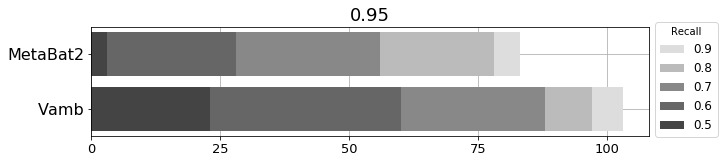

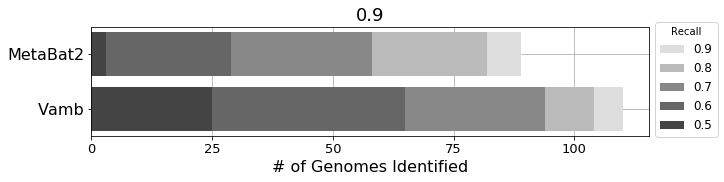

In [48]:
for precision in 0.95, 0.9:

    plt.figure(figsize=(10, 2))
    colors = ['#DDDDDD', '#BBBBBB', '#888888', '#666666', '#444444']
    recalls = [0.5, 0.6, 0.7, 0.8, 0.9]
    for y, benchmark in zip((0, 1), (result, metabatresult)):
        for color, recall in zip(colors, recalls):
            plt.barh(y, benchmark[recall, precision], color=color)

    plt.title(str(precision), fontsize=18)
    plt.yticks([0, 1], ['Vamb', 'MetaBat2'], fontsize=16)
    plt.xticks([i*25 for i in range(5)], fontsize=13)
    plt.legend([str(i) for i in reversed(recalls)], bbox_to_anchor=(1, 1.1), title='Recall', fontsize=12)
    
    if precision == 0.9:
        plt.xlabel('# of Genomes Identified', fontsize=16)
    plt.gca().set_axisbelow(True)
    plt.grid()